In [140]:
import torch
import torchvision
import sys
import pickle
from re import split
import sys
sys.path.append('../src/')
import os
import matplotlib.pyplot as plt
# torch.multiprocessing.set_start_method('spawn')
import numpy as np
from scipy.io import loadmat
import glob
import shutil
import pandas as pd
from scipy.stats import spearmanr

from utils.datasets import ImageNetDataset, ActivationTransform
from masking.hooked_model import HookedModel
from masking.activation_model import ActivationModel
from training.train import train, save_model, save_logger, create_eval_callback
from utils.dist_metrics import lin_cka_dist_2, procrustes_2, cca_decomp_kernel_trick, pwcca_dist, mean_sq_cca_corr, mean_cca_corr

In [18]:
torch.cuda.is_available()

True

In [3]:
class LinearModel(torch.nn.Module):
    def __init__(self,dim):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(dim,1000)
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self,x):
        x = self.linear(x)
        return x
    
    @property
    def loss_criterion(self):
        return self.criterion

In [4]:
# for size in range(1000000,10000000,500000):
#     print(size)
#     torch.cuda.empty_cache()
#     model = LinearModel(size).to('cuda')
#     out = model(torch.rand(size).to('cuda'))
#     del model
#     del out

In [5]:
a = pickle.load(open('../../data/alexnet/activations/00000011.pkl','rb'),encoding='bytes')

In [19]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /home/snag-lab/.cache/torch/hub/pytorch_vision_v0.10.0
/home/snag-lab/anaconda3/envs/torch113/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/snag-lab/anaconda3/envs/torch113/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
[m for n,m in model.named_modules()]

[MobileNetV2(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU6(inplace=True)
     )
     (1): InvertedResidual(
       (conv): Sequential(
         (0): Conv2dNormActivation(
           (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
           (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): ReLU6(inplace=True)
         )
         (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
     )
     (2): InvertedResidual(
       (conv): Sequential(
         (0): Conv2dNormActivation(
           (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (1

In [20]:
layer_types = ['torch.nn.ReLU']
# layer_types = ['torchvision.models.resnet.Bottleneck']
# layer_types = ['torchvision.models.mobilenetv2.InvertedResidual']
layer_modules = ['.'.join(split('\.',l)[:-1]) for l in layer_types]
layer_types = [split('\.',l)[-1] for l in layer_types]
layers = [n for n,m in model.named_modules() if 
            np.any([isinstance(m,getattr(sys.modules[layer_modules[i]], layer_types[i])) for i in range(len(layer_types))])]

In [5]:
layer_types = ['torch.nn.ReLU6']
layer_modules = ['.'.join(split('\.',l)[:-1]) for l in layer_types]
layer_types = [split('\.',l)[-1] for l in layer_types]
layers = [n for n,m in model.named_modules() if 
            np.any([isinstance(m,getattr(sys.modules[layer_modules[i]], layer_types[i])) for i in range(len(layer_types))])]

In [21]:
layers

['features.1',
 'features.4',
 'features.7',
 'features.9',
 'features.11',
 'classifier.2',
 'classifier.5']

In [9]:
image_transforms = [torchvision.transforms.Resize(256),
                    torchvision.transforms.CenterCrop(224)]
tensor_transforms = [torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]

layer = layers[0]

# create activation_model
activation_model = ActivationModel(model,layer)

# load data
train_dataset = ImageNetDataset(os.path.join('/media/datadrive/ILSVRC/Data/CLS-LOC','train'),image_transforms,tensor_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=1024, shuffle=True,num_workers=8,pin_memory=True)

val_dataset = ImageNetDataset(os.path.join('/media/datadrive/ILSVRC/Data/CLS-LOC','train'),image_transforms,tensor_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=1024, shuffle=False,num_workers=8,pin_memory=True)

# get shape of activation output
inputs, _ = next(iter(train_loader))
activations = activation_model(inputs)
activations = activations.flatten(1)

# # initialize decoder
# linear_model = LinearModel(activations.shape[-1])
# linear_model.to('cuda')

# # initialize optimizer
# # optimizer = torch.optim.SGD(
# #     linear_model.parameters(),
# #     lr=0.1,
# #     momentum=0,
# #     weight_decay=0,
# # )

# optimizer = torch.optim.Adam(
#     linear_model.parameters(),
#     lr=1e-4,
#     weight_decay=0
# )

# # callbacks
# callbacks = [
#     save_model,
#     create_eval_callback('train', train_loader, verbose=True),
#     # create_eval_callback('val', val_loader, verbose=True),
#     save_logger,
# ]

# # train decoder
# train(linear_model,
#         optimizer,
#         train_loader,
#         os.path.join("/home/snag-lab/Documents/rsa_tmlr_2023/data/alexnet/causal_linear_probes",layer),
#         callbacks=[],
#         preprocessing_model=activation_model)

: 

: 

In [11]:
# # train_dataset = ImageNetDataset(os.path.join('/media/datadrive/ILSVRC/Data/CLS-LOC','train'),image_transforms,tensor_transforms)
# # train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=1024, shuffle=True, num_workers=8)

# train_dataset = ImageNetDataset(os.path.join('/media/datadrive/ILSVRC/Data/CLS-LOC','train'),image_transforms,tensor_transforms)
# train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=1024, shuffle=True,num_workers=8)

# for it, (examples, labels) in enumerate(train_loader):
#     print(it)

In [ ]:
activations.shape

torch.Size([1024, 4096])

In [4]:
len(os.listdir(os.path.join('/media/datadrive/ILSVRC/Data/CLS-LOC','val')))

50000

In [8]:
def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:n_max_synsets]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    return wids

#Load the details of all the 1000 classes and the function to convert the synset id to words
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

#Load the ground truth labels to measure the performance
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1

# Get list of all animate and inanimate images
im_valid_test = glob.glob(os.path.join('/media/datadrive/ILSVRC/Data/CLS-LOC','val','*'))
im_valid_test = np.asarray(im_valid_test)

# Make list of wids
true_valid_wids = []
for i in im_valid_test:
    temp1 = i.split('/')[-1]
    temp = temp1.split('.')[0].split('_')[-1]
    true_valid_wids.append(truth[int(temp)][1])
true_valid_wids = np.asarray(true_valid_wids)

In [10]:
len(true_valid_wids)

50000

In [11]:
im_valid_test

array(['/media/datadrive/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00013166.JPEG',
       '/media/datadrive/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00003766.JPEG',
       '/media/datadrive/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00042974.JPEG',
       ...,
       '/media/datadrive/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00033520.JPEG',
       '/media/datadrive/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00047800.JPEG',
       '/media/datadrive/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00018526.JPEG'],
      dtype='<U69')

In [15]:
for i,file in enumerate(im_valid_test):
    print(split('\/',file)[-1],true_valid_wids[i])
    if not os.path.isdir(os.path.join('/media/datadrive/ILSVRC/Data/CLS-LOC/val',true_valid_wids[i])):
        os.makedirs(os.path.join('/media/datadrive/ILSVRC/Data/CLS-LOC/val',true_valid_wids[i]))
    shutil.copy(file,os.path.join('/media/datadrive/ILSVRC/Data/CLS-LOC/val',true_valid_wids[i],split('\/',file)[-1]))

ILSVRC2012_val_00013166.JPEG n01608432
ILSVRC2012_val_00003766.JPEG n02445715
ILSVRC2012_val_00042974.JPEG n06785654
ILSVRC2012_val_00014691.JPEG n04483307
ILSVRC2012_val_00018517.JPEG n02012849
ILSVRC2012_val_00021385.JPEG n01978455
ILSVRC2012_val_00016176.JPEG n03876231
ILSVRC2012_val_00010916.JPEG n03916031
ILSVRC2012_val_00049344.JPEG n02106550
ILSVRC2012_val_00029012.JPEG n03187595
ILSVRC2012_val_00016948.JPEG n04435653
ILSVRC2012_val_00041168.JPEG n01514859
ILSVRC2012_val_00010978.JPEG n03706229
ILSVRC2012_val_00028781.JPEG n02910353
ILSVRC2012_val_00022690.JPEG n04501370
ILSVRC2012_val_00009014.JPEG n02110063
ILSVRC2012_val_00008799.JPEG n07248320
ILSVRC2012_val_00048470.JPEG n03126707
ILSVRC2012_val_00011153.JPEG n03876231


FileExistsError: [Errno 17] File exists: '/media/datadrive/ILSVRC/Data/CLS-LOC/val/n03876231'

In [39]:
classes = ['schooner','brain_coral','junco_bird','snail','grey_whale','siberian_husky','electric_fan','bookcase','fountain_pen','toaster','balance_beam',
            'school_bus','chainlink_fence','chime','coyote','aircraft_carrier','bubble','jellyfish','marmoset','wall_clock','water_snake','Welsh_springer_spaniel',
            'Arctic_fox','football_helmet','slug','potpie','Pomeranian','Indian_cobra','beach_wagon','Italian_greyhound','European_fire_salamander','chimpanzee',
            'typewriter_keyboard','black_and_gold_garden_spider','tick','toy_terrier','switch','lighter','guillotine','otterhound','boxer','hook','jersey',
            'soap_dispenser','umbrella','tiger_beetle','cash_machine','eel','Blenheim_spaniel','clumber']
class_wids = ['n04147183','n01917289','n01534433','n01944390','n02066245','n02110185','n03271574','n02870880','n03388183','n04442312','n02777292',
            'n04146614','n03000134','n03017168','n02114855','n02687172','n09229709','n01910747','n02490219','n04548280','n01737021','n02102177','n02120079','n03379051',
            'n01945685','n07875152','n02112018','n01748264','n02814533','n02091032','n01629819','n02481823','n04505470','n01773157','n01776313','n02087046','n04372370',
            'n03666591','n03467068','n02091635','n02108089','n03532672','n03595614','n04254120','n04507155','n02165105','n02977058','n02526121','n02086646','n02101556']

classes_dict = dict(zip(class_wids,classes))

In [4]:
len(classes_dict)

50

In [40]:
pickle.dump(classes_dict, open('/media/datadrive/rsa_tmlr_2023/data/50_classes.pkl','wb'))

In [35]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
category_name = weights.meta["categories"][844]
print(category_name)

switch


In [22]:
act = ActivationModel(model,'classifier.5')

In [37]:
for im in glob.glob('/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/*'):
    act = pickle.load(open(im,'rb'))
    break

UnicodeDecodeError: 'ascii' codec can't decode byte 0xb7 in position 0: ordinal not in range(128)

In [38]:
print(im)

/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00007411.pkl


In [28]:
act['classifier.5'].shape

torch.Size([1, 4096])

In [29]:
for im in glob.glob('/media/datadrive/alexnet/activations/*'):
    act2 = pickle.load(open(im,'rb'))
    break

In [31]:
np.allclose(act2['classifier.2'].cpu(), act['classifier.2'].cpu())

True

In [36]:
logits = pickle.load(open('../../data/alexnet/baseline_logits.pkl','rb'))
print(logits.shape)

(2500, 1000)


In [41]:
class_id_to_idx = {class_id:index for index,class_id in enumerate(sorted(os.listdir('/media/datadrive/ILSVRC/Data/CLS-LOC/val')))}

In [43]:
pickle.dump(class_id_to_idx, open('/media/datadrive/rsa_tmlr_2023/data/class_id_to_index.pkl','wb'))

In [45]:
df = pd.read_csv('/media/datadrive/rsa_tmlr_2023/data/tmlr_rebuttal_results_alexnet.csv')

In [48]:
df

,Unnamed: 0,network,layer,class,cell,linear decoding delta,downstream network delta
0,0,alexnet,features.1,schooner,0,-0.032550,13.312056
1,1,alexnet,features.1,schooner,1,-0.066521,13.325520
2,2,alexnet,features.1,schooner,2,-0.121046,13.306736
3,3,alexnet,features.1,schooner,3,-0.391213,13.277133
4,4,alexnet,features.1,schooner,4,-0.008080,13.295459
...,...,...,...,...,...,...,...
5595,5595,alexnet,classifier.5,clumber,11,-0.126192,15.746002
5596,5596,alexnet,classifier.5,clumber,12,-0.088257,15.810651
5597,5597,alexnet,classifier.5,clumber,13,-0.222227,15.714682
5598,5598,alexnet,classifier.5,clumber,14,-0.258283,15.709429


In [47]:
df.groupby('cell')['linear decoding delta'].mean()

cell
0    -0.015051
1    -0.040477
2    -0.075973
3    -0.193868
4    -0.014094
5    -0.046540
6    -0.079297
7    -0.155152
8    -0.021702
9    -0.061076
10   -0.087988
11   -0.131954
12    0.016710
13    0.070626
14    0.249826
15    1.875601
Name: linear decoding delta, dtype: float64

In [50]:
df.groupby(['cell','layer'])['downstream network delta'].mean()

cell  layer       
0     classifier.2    11.081684
      classifier.5    11.093576
      features.1      11.088660
      features.11     11.090141
      features.4      11.083599
                        ...    
15    features.1      11.682014
      features.11     12.347028
      features.4      11.851714
      features.7      12.078642
      features.9      12.275456
Name: downstream network delta, Length: 112, dtype: float64

In [54]:
for file in glob.glob('/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/*'):
    act = pickle.load(open(file,'rb'))
    for k,v in act.items():
        print(v.device)
        act[k] = v.cpu()
        print(act[k].device)
    pickle.dump(act,open(file,'wb'))

cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu
cuda:0
cpu

In [91]:
for file in glob.glob('/media/datadrive/rsa_tmlr_2023/data/mobilenet/activations/*'):
    act = pickle.load(open(file,'rb'))[0]
    break

In [93]:
act.shape

(5726552,)

In [59]:
df = pd.read_csv('/media/datadrive/rsa_tmlr_2023/data/alexnet/tmlr_rebuttal_results_distances_alexnet.csv')

In [60]:
df

,Unnamed: 0,network,layer,class,cell,cka,procrustes
0,0,alexnet,features.1,schooner,0,0.000492,0.000546
1,1,alexnet,features.1,schooner,1,0.000849,0.000859
2,2,alexnet,features.1,schooner,2,0.002835,0.001833
3,3,alexnet,features.1,schooner,3,0.047773,0.015686
4,4,alexnet,features.1,schooner,4,0.000142,0.000211
...,...,...,...,...,...,...,...
859,859,alexnet,features.4,snail,11,0.001371,0.001005
860,860,alexnet,features.4,snail,12,0.000329,0.000345
861,861,alexnet,features.4,snail,13,0.000911,0.000819
862,862,alexnet,features.4,snail,14,0.001699,0.001501


In [61]:
df.to_csv('/media/datadrive/rsa_tmlr_2023/data/alexnet/tmlr_rebuttal_results_distances_alexnet_copy.csv')

In [102]:
ablation_results = pd.read_csv('/media/datadrive/rsa_tmlr_2023/data/resnet/tmlr_rebuttal_results_resnet.csv',index_col=0)
# distance_results = pd.read_csv('/media/datadrive/rsa_tmlr_2023/data/resnet/tmlr_rebuttal_results_distances_no_cca_mobilenet.csv',index_col=0)
for i,f in enumerate(glob.glob('/media/datadrive/rsa_tmlr_2023/data/resnet/tmlr_rebuttal_results_distances_resnet_layer*.csv')):
    if i == 0:
        distance_results_cca = pd.read_csv(f,index_col=0)
    else:
        distance_results_cca = pd.concat([distance_results_cca,pd.read_csv(f,index_col=0)],axis=0)

In [103]:
distance_results_cca

,network,layer,class,cell,cka,procrustes,pwcca,mean cca,mean sq cca
0,resnet,layer3.1,schooner,0,0.000619,0.000440,0.257726,0.695641,0.496180
1,resnet,layer3.1,schooner,1,0.000801,0.000574,0.259293,0.693925,0.493859
2,resnet,layer3.1,schooner,2,0.000931,0.000714,0.260351,0.692769,0.492299
3,resnet,layer3.1,schooner,3,0.001862,0.001376,0.262075,0.691138,0.489962
4,resnet,layer3.1,schooner,4,0.000095,0.000102,0.254938,0.698782,0.500396
...,...,...,...,...,...,...,...,...,...
795,resnet,layer3.5,clumber,11,0.000639,0.000527,0.343701,0.615437,0.390427
796,resnet,layer3.5,clumber,12,0.000284,0.000218,0.339360,0.619961,0.395947
797,resnet,layer3.5,clumber,13,0.000639,0.000423,0.341804,0.617346,0.392796
798,resnet,layer3.5,clumber,14,0.001281,0.000764,0.343460,0.615608,0.390688


In [104]:
df = pd.merge(ablation_results,distance_results_cca,on=['network','class','layer','cell'])
# df = pd.merge(df,distance_results_cca,on=['network','class','layer','cell'])

In [105]:
df.groupby(['network','layer']).count()

class  cell  linear decoding delta  \
network layer                                          
resnet  layer3.0    800   800                    800   
        layer3.1    800   800                    800   
        layer3.2    800   800                    800   
        layer3.3    800   800                    800   
        layer3.4    800   800                    800   
        layer3.5    800   800                    800   

                  downstream network delta  cka  procrustes  pwcca  mean cca  \
network layer                                                                  
resnet  layer3.0                       800  800         800    800       800   
        layer3.1                       800  800         800    800       800   
        layer3.2                       800  800         800    800       800   
        layer3.3                       800  800         800    800       800   
        layer3.4                       800  800         800    800       800   
        layer3.5                       800  800         800    800       800   

                  mean sq cca  
network layer                  
resnet  layer3.0          800  
        layer3.1          800  
        layer3.2          800  
        layer3.3          800  
        layer3.4          800  
        layer3.5          800

In [106]:
for a in ['linear decoding delta','downstream network delta']:
    for b in ['cka', 'procrustes','pwcca', 'mean cca', 'mean sq cca']:
        d2 = pd.DataFrame([],columns=['class','layer','correlation','pvalue'])
        for cl in df['class'].unique():
            for layer in df['layer'].unique():
                data = df[(df['class']==cl) & (df['layer']==layer)]
                corr,p = spearmanr(data[a],data[b])
                d2.loc[len(d2)] = [cl,layer,corr,p]
        d2.to_csv('../../data/resnet/resnet_'+a+'_X_'+b+'.csv')

In [101]:
d2

,class,layer,correlation,pvalue
0,schooner,features.1,0.138235,0.609666
1,schooner,features.2,0.050000,0.854100
2,schooner,features.3,0.441176,0.087154
3,schooner,features.4,-0.414706,0.110229
4,schooner,features.5,0.485294,0.056718
...,...,...,...,...
845,clumber,features.13,-0.488595,0.054810
846,clumber,features.14,-0.300000,0.258936
847,clumber,features.15,-0.147059,0.586793
848,clumber,features.16,0.073529,0.786679


In [124]:
network = 'mobilenet'
df = pd.read_csv('/media/datadrive/rsa_tmlr_2023/data/'+network+'/tmlr_rebuttal_results_'+network+'.csv',index_col=0)

In [125]:
a = df.groupby(['cell'])['downstream network delta'].mean()

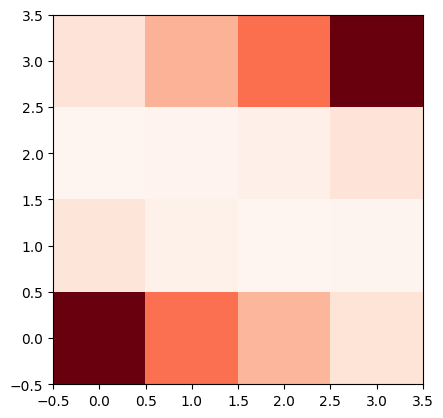

In [126]:
plt.imshow(a.to_numpy().reshape(4,4),origin='lower',cmap='Reds')

In [127]:
a = df.groupby(['cell'])['linear decoding delta'].mean()

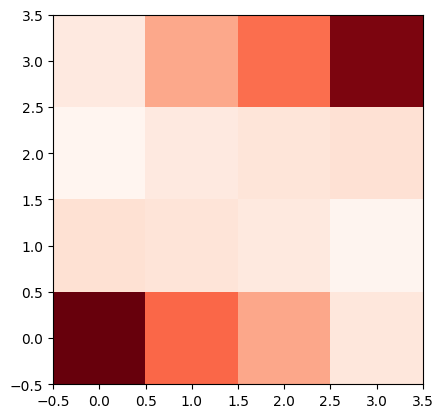

In [128]:
plt.imshow(a.to_numpy().reshape(4,4),origin='lower',cmap='Reds')

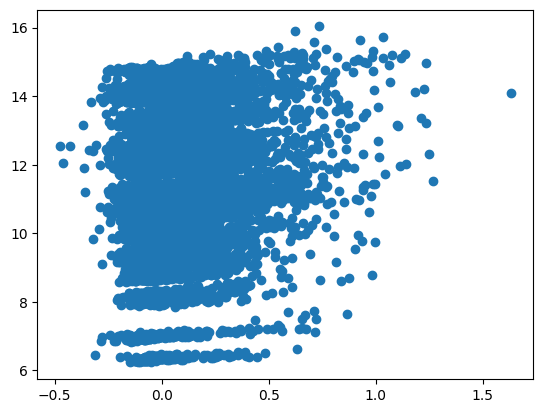

In [129]:
plt.scatter(df['linear decoding delta'],df['downstream network delta'])


In [130]:
for a in ['linear decoding delta']:
    for b in ['downstream network delta']:
        d2 = pd.DataFrame([],columns=['class','layer','correlation','pvalue'])
        for cl in df['class'].unique():
            for layer in df['layer'].unique():
                data = df[(df['class']==cl) & (df['layer']==layer)]
                corr,p = spearmanr(data[a],data[b])
                d2.loc[len(d2)] = [cl,layer,corr,p]
        # d2.to_csv('../../data/resnet/resnet_'+a+'_X_'+b+'.csv')

In [133]:
d2.sort_values('layer').groupby('layer')['correlation'].mean()

layer
features.1     0.177353
features.10    0.680412
features.11    0.683235
features.12    0.747294
features.13    0.745824
features.14    0.803294
features.15    0.841059
features.16    0.849000
features.17    0.964235
features.2     0.149588
features.3     0.309882
features.4     0.483118
features.5     0.504941
features.6     0.574353
features.7     0.621941
features.8     0.614471
features.9     0.658059
Name: correlation, dtype: float64

In [134]:
df

,network,layer,class,cell,linear decoding delta,downstream network delta
0,mobilenet,features.1,schooner,0,0.616386,13.312696
1,mobilenet,features.1,schooner,1,0.073183,13.224105
2,mobilenet,features.1,schooner,2,-0.049778,13.233324
3,mobilenet,features.1,schooner,3,-0.369386,13.165688
4,mobilenet,features.1,schooner,4,-0.095567,13.276412
...,...,...,...,...,...,...
13595,mobilenet,features.17,clumber,11,-0.098665,12.855297
13596,mobilenet,features.17,clumber,12,-0.037264,12.922860
13597,mobilenet,features.17,clumber,13,0.058831,13.035861
13598,mobilenet,features.17,clumber,14,0.123151,13.057732


(array([ 47.,  63.,  31., 114., 215.,  99., 320., 258., 401., 377., 326.,
        174., 100., 171.,  91., 165., 163.,  85.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  67.,  33.,  63., 136., 176.,  76., 153.,  91.,   5.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  49.,  47.,  51., 124.,  50., 161.,  68., 150.,  22.,
         78.]),
 array([0.24977964, 0.25074237, 0.25170509, 0.25266782, 0.25363055,
        0.25459327, 0.255556  , 0.25651873, 0.25748145, 0.25844418,
        0.25940691, 0.26036963, 0.26133236, 0.26229509, 0.26325781,
        0.26422054, 0.26518327, 0.26614599, 0.26710872, 0.26807145,
        0.26903417, 0.2699969 , 0.27095963, 0.

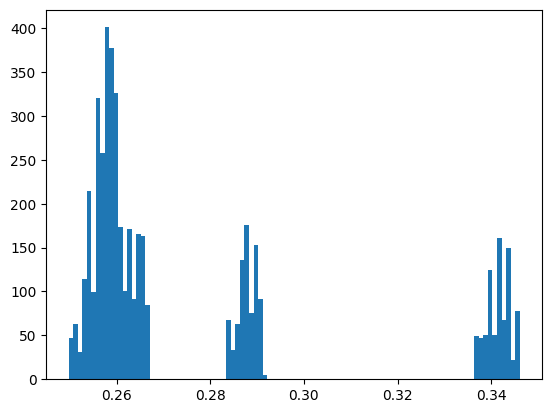

In [135]:
plt.hist(distance_results_cca['pwcca'],bins=100)

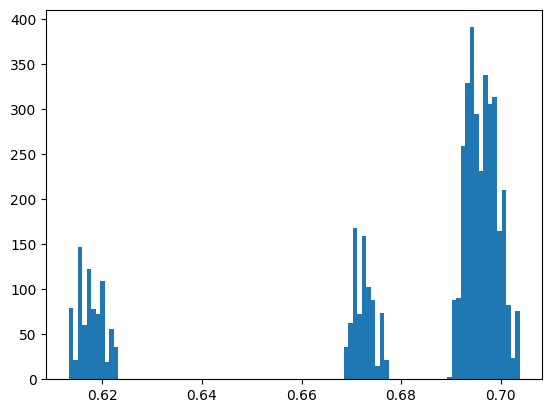

In [136]:
plt.hist(distance_results_cca['mean cca'],bins=100)
plt.show()

(array([ 80.,  20., 156.,  63., 158.,  45., 124.,  55.,  33.,  65.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  58.,  59., 165., 109., 110., 127.,  67.,
         13.,  82.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  34., 205., 224.,
        398., 343., 293., 210., 282., 343., 305., 104., 230.,  91.,  67.,
         71.]),
 array([0.3875949 , 0.38878446, 0.38997402, 0.39116357, 0.39235313,
        0.39354269, 0.39473225, 0.3959218 , 0.39711136, 0.39830092,
        0.39949048, 0.40068003, 0.40186959, 0.40305915, 0.40424871,
        0.40543827, 0.40662782, 0.40781738, 0.40900694, 0.4101965 ,
        0.41138605, 0.41257561, 0.41376517, 0.

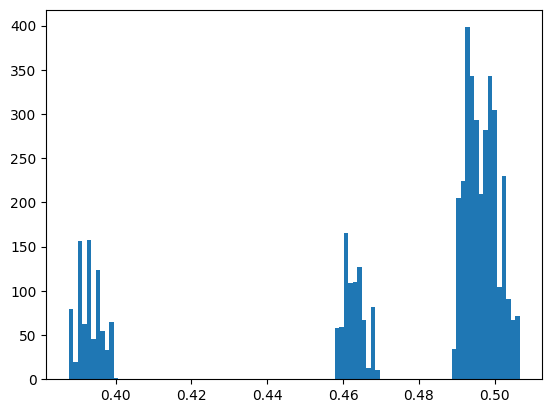

In [137]:
plt.hist(distance_results_cca['mean sq cca'],bins=100)

In [176]:
layer_activations = []
for im in glob.glob('/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/*'):
    print(im)
    layer_activations.append(pickle.load(open(im,'rb'))['classifier.5'])
layer_activations = np.row_stack(layer_activations)

/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00007411.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00008087.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00012884.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00047124.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00025713.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00009313.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00041016.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00019124.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00014772.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00018014.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00007385.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00021736.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00032493.pkl
/media/datadrive/rsa_tmlr_2023/data/alexnet/activations/00049917.pkl
/media/datadrive/rsa_tmlr_2023/dat

In [177]:
layer_activations = layer_activations - np.mean(layer_activations,axis=0)

In [193]:


sims = pd.DataFrame([],columns=['ablation','pen','pwcca'])
for a in range(100):
    intact_indexes = np.random.choice(np.arange(layer_activations.shape[1]),int(15*layer_activations.shape[1]/16))
    intact_activations = layer_activations[:,intact_indexes]

    for pen in [1e-10,1e-3,1e-1,10,1000]:
        _, cca_rho, _, transformed_rep1, _ = cca_decomp_kernel_trick(
                                                                    torch.from_numpy(layer_activations).to('cuda'), 
                                                                    torch.from_numpy(intact_activations).to('cuda'),
                                                                    pen_a=pen,pen_b=pen,
                                                                    )
        pwcca_sim = pwcca_dist(torch.from_numpy(layer_activations).T.to('cuda'), cca_rho, transformed_rep1).cpu().numpy()
        print(a,pen,pwcca_sim)
        sims.loc[len(sims)] = [a, pen, pwcca_sim]

0 1e-10 0.12323272
0 0.001 0.14686698
0 0.1 0.16014087
0 10 0.17601985
0 1000 0.34430534
1 1e-10 0.12976146
1 0.001 0.15706134
1 0.1 0.17513084
1 10 0.18731815
1 1000 0.3509038
2 1e-10 0.12716317
2 0.001 0.15397727
2 0.1 0.16785783
2 10 0.1835038
2 1000 0.34785157
3 1e-10 0.13163859
3 0.001 0.16155607
3 0.1 0.17715979
3 10 0.19173181
3 1000 0.3553878
4 1e-10 0.12988967
4 0.001 0.15650266
4 0.1 0.17157513
4 10 0.18561095
4 1000 0.35188127


In [187]:
corrs = [[0,0,0,0,0] for _ in range(5)]
for i,a in enumerate([1e-10,1e-3,1e-1,10,1000]):
    for j,b in enumerate([1e-10,1e-3,1e-1,10,1000]):
        corrs[i][j] = spearmanr(sims[sims['pen']==a]['pwcca'], sims[sims['pen']==b]['pwcca'])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 100 and the array at index 1 has size 200

In [189]:
sims[sims['pen']==b]['pwcca']

1       0.3563457
4       0.3563457
6      0.34899527
9      0.34899527
11     0.34967214
          ...    
489    0.34934092
491    0.35140342
494    0.35140342
496     0.3486517
499     0.3486517
Name: pwcca, Length: 200, dtype: object

In [190]:
b

1000.0

In [191]:
sims.groupby('pen').count()

,ablation,pwcca
pen,,
1.000000e+01,200,200
1.000000e+03,200,200
1.000000e+10,100,100
